
# Mini Project 01 : Analysis of Residential Property in the Korean Urban Area

Dongjin Lee

Part 02: Analysis


Coding Note : 
Due to origin of the data source, many of the coding was consist of Korean.
The translation of analysis was done after all the work is completed.




In [1]:
"""
Created on Mon Apr 11 18:30:05 2016
"""
# import packages 
import pandas as pd                   # data management
import matplotlib.pyplot as plt       # graphics 
import matplotlib as mpl              # graphics parameters
import numpy as np                    # numerical calculations 


# Checking Python version 
import datetime as dt 
import sys
print('Today is', dt.date.today())
print('What version of Python are we running? \n', sys.version, sep='') 

# Additional Packages
import scipy as sp
from scipy import stats  
from matplotlib import rcParams
from matplotlib import cm, colors, _cm
import sqlite3

Today is 2016-04-22
What version of Python are we running? 
3.5.1 |Anaconda 4.0.0 (64-bit)| (default, Feb 16 2016, 09:49:46) [MSC v.1900 64 bit (AMD64)]


In [2]:
%matplotlib inline
plt.style.use('ggplot')

In [4]:
con = sqlite3.connect("/Users/goodvc/Documents/data/sqllite/realestate_db.db")

In [7]:
def short_distr(name):
    wide, narrow = name.split()
    if narrow.endswith('구'):
        return wide[:2] + (narrow[:-1] if len(narrow) > 2 else narrow)
    elif narrow == '고성군': # 고성군은 강원도, 경상남도에 있다.
        return '고성({})'.format({'강원도': '강원', '경상남도': '경남'}[wide])
    else:
        return narrow[:-1]

apt_data['shortname'] = list(map(short_distr, apt_data['sigu']))
rep = """경기고양덕양:고양 경기고양일산동:고양 경기고양일산서:고양 경기부천소사:부천 경기부천오정:부천 경기부천원미:부천 
경기성남분당:성남 경기성남수정:성남 경기성남중원:성남 경기수원권선:수원 경기수원영통:수원 경기수원장안:수원 경기수원팔달:수원
경기안산단원:안산 경기안산상록:안산 경기안양동안:안양 경기안양만안:안양 경기용인기흥:용인 경기용인수지:용인 경기용인처인:용인 
경상창원마산합포:창원 경상창원마산회원:창원 경상창원성산:창원 경상창원의창:창원 경상창원진해:창원 
경상포항남:포항 경상포항북:포항 세종특별자치:세종 전라전주덕진:전주 전라전주완산:전주 충청천안동남:안동 충청천안서북:천안 
충청청주상당:청주 충청청주서원:청주 충청청주청원:청주 충청청주흥덕:청주"""
sn_aliases = dict(aliasset.split(':') for aliasset in rep.split())

rep = """고양덕양:고양시 고양일산동:고양시 고양일산서:고양시 부천소사:부천시 부천오정:부천시 부천원미:부천시 
성남분당:성남시 성남수정:성남시 성남중원:성남시 수원권선:수원시 수원영통:수원시 수원장안:수원시 수원팔달:수원시
안산단원:안산시 안산상록:안산시 안양동안:안양시 안양만안:안양시 용인기흥:용인시 용인수지:용인시 용인처인:용인시
창원마산합포:창원시 창원마산회원:창원시 창원성산:창원시 창원의창:창원시 창원진해:창원시
포항남:포항시 포항북:포항시 세종특별자치:세종시 전주덕진:전주시 전주완산:전주시 천안동남:안동시 천안서북:천안시 
청주상당:청주시 청주서원:청주시 청주청원:청주시 청주흥덕:청주시"""

gu_aliases = dict(aliasset.split(':') for aliasset in rep.split())
apt_data['shortname'] = apt_data['shortname'].apply(lambda v: sn_aliases.get(v, v))
apt_data['gu'] = apt_data['gu'].apply(lambda v: gu_aliases.get(v[:-1], v))

gu_grouped = apt_data[apt_data['KAPT_USEDATE']>0].groupby(['shortname'])
apt_ds = gu_grouped.agg({'si':np.max, 'gu':np.max, 'kcode':np.size, \
                      'KAPTDA_CNT':np.sum,'KAPTDA_CNT1':np.sum,'KAPTDA_CNT2':np.sum,'KAPTDA_CNT3':np.sum,'KAPTDA_CNT4':np.sum,\
                      'KAPT_USEDATE':np.mean}).sort(['KAPT_USEDATE'], ascending=False)  
apt_ds.head(2)

,KAPTDA_CNT,KAPTDA_CNT4,KAPTDA_CNT3,gu,KAPT_USEDATE,kcode,KAPTDA_CNT1,KAPTDA_CNT2,si
shortname,,,,,,,,,
영양,200,0,0,영양군,2013.000000,1,200,0,경상북도
부산강서,15832,2515,6121,강서구,2011.176471,17,1032,6164,부산광역시


In [9]:
apt_ds = pd.merge(apt_ds, blockpositions_tbl, how='left', left_index=True, right_index=True)
apt_ds.head(2)

,KAPTDA_CNT,KAPTDA_CNT4,KAPTDA_CNT3,gu,KAPT_USEDATE,kcode,KAPTDA_CNT1,KAPTDA_CNT2,si,x,y
shortname,,,,,,,,,,,
영양,200,0,0,영양군,2013.000000,1,200,0,경상북도,11,10
부산강서,15832,2515,6121,강서구,2011.176471,17,1032,6164,부산광역시,8,18



* Section 01 =~60㎡ 이하, 
* Section 02 =60㎡~85㎡
* Section 03 =85㎡~135㎡
* Section 04 =135㎡~ 

In [11]:
apt_ds.rename(columns={'KAPTDA_CNT1': '소형','KAPTDA_CNT2': '중소형'\
                       ,'KAPTDA_CNT3': '중대형','KAPTDA_CNT4': '대형'\
                       ,'KAPTDA_CNT': '합계'}, inplace=True)

또한 국민 주택 규모인 85㎡를 기준으로 소형/대형으로 나누어서 측정해 보자 

In [13]:
apt_ds['소형(계)'] = apt_ds['소형']+apt_ds['중소형']
apt_ds['대형(계)'] = apt_ds['대형']+apt_ds['중대형']

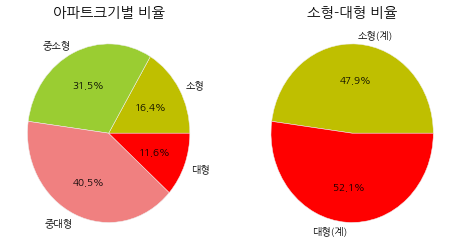

In [14]:
area1 = apt_ds[['소형','중소형','중대형','대형']].sum()
area2 = apt_ds[['소형(계)','대형(계)']].sum()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
axes[0].set_title('아파트크기별 비율')
area1.plot(kind='pie', figsize=(4,4),colors=('y','yellowgreen', 'lightcoral', 'r'), autopct='%1.1f%%'\
                , subplots=True , ax=axes[0])
axes[1].set_title('소형-대형 비율')
area2.plot(kind='pie', figsize=(4,4),colors=('y','r'), autopct='%1.1f%%'\
                , subplots=True , ax=axes[1])
plt.show()


In [15]:
grouped = apt_ds.groupby(['si'])

In [16]:
area1 = grouped.agg({'소형(계)':np.sum,'대형(계)':np.sum, '합계':np.sum } , as_index=False ).sort(['합계'])
area1['소형(비율)'] = area1['소형(계)'] /  area1['합계']
area1['대형(비율)'] = area1['대형(계)'] /  area1['합계']

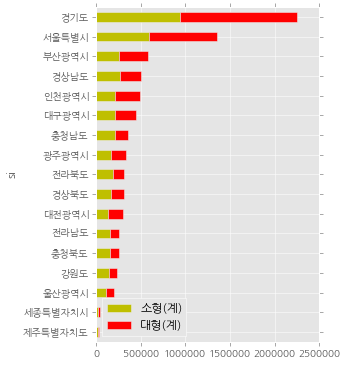

In [17]:
area1[['소형(계)','대형(계)']].plot(kind='barh', stacked=True, color =('y','r'), title='',figsize=(4,6))

지역별 예산가 개인소득 정보를 가져와서 비교해 보자 

In [19]:
# 시도별 예산규모 (총괄)
list = '''서울특별시 342,751 144,328 50,993 2,231 50,362 18,603 18,182 9,560 48,492 80.0 81.2
부산광역시 122,222 34,647 12,207 10,658 37,213 6,932 4,639 4,746 11,180 51.4 66.6
대구광역시 87,347 22,474 6,545 10,663 28,021 5,289 2,830 2,709 8,816 46.1 67.6
인천광역시 113,513 30,741 19,157 5,658 28,964 6,534 3,474 8,436 10,549 62.6 71.8
광주광역시 51,727 12,174 4,115 6,247 18,373 3,470 1,946 1,516 3,886 41.9 62.5
대전광역시 50,277 13,466 4,092 4,683 15,145 4,429 1,722 1,055 5,685 49.4 66.6
울산광역시 42,370 14,002 4,300 1,888 10,054 2,285 1,799 850 7,192 61.4 69.4
세종특별자치시 7,606 2,534 845 1,540 1,616 - - 95 976 47.6 77.3
경기도 402,961 132,107 51,285 22,502 102,446 14,558 17,132 7,907 55,024 61.2 71.5
강원도 108,044 13,129 7,398 33,219 38,622 3,698 1,229 1,346 9,403 22.2 68.3
충청북도 90,517 13,938 5,282 22,582 31,445 4,620 1,739 1,880 9,031 26.6 66.1
충청남도 123,874 22,517 9,383 27,731 43,986 5,731 2,503 2,158 9,865 30.2 65.9
전라북도 121,950 14,730 7,963 30,795 50,610 5,359 1,666 2,130 8,697 22.8 63.1
전라남도 145,248 15,186 6,923 43,012 62,005 5,092 1,317 1,748 9,965 17.4 62.4
경상북도 184,801 24,699 10,884 51,265 66,175 7,701 2,586 2,656 18,835 22.7 66.1
경상남도 172,326 35,739 12,992 31,873 57,850 7,730 4,793 1,575 19,774 36.0 66.5
제주특별자치도 35,825 7,545 2,275 9,459 11,343 - - 700 4,503 30.1 66.9 '''.replace(',','').split()
dim2 = np.reshape(list,(17,12))
budget = pd.DataFrame(dim2[:,1], index=dim2[:,0], columns=['총예산']).astype(float)

In [20]:
# GDP 
list = """ 서울특별시 부산광역시 대구광역시 인천광역시 광주광역시 대전광역시 울산광역시 경기도 강원도 충청북도 충청남도 전라북도 전라남도 경상북도 경상남도 제주특별자치도
1,752 1,505 1,431 1,380 1,405 1,489 1,831 1,429 1,288 1,339 1,340 1,315 1,249 1,343 1,379 1,441
""".replace(",","").split()

gdp = pd.DataFrame(list[16:], index=list[0:16], columns=['1인당개인소득']).astype(float)

In [21]:
#Data Merga
merge = area1.join(budget).join(gdp).dropna()
merge = merge[['대형(비율)','총예산','1인당개인소득']].sort(['대형(비율)'])

In [22]:
merge.head()

,대형(비율),총예산,1인당개인소득
si,,,
제주특별자치도,0.359271,35825,1441
충청북도,0.385218,90517,1339
전라남도,0.389766,145248,1249
강원도,0.395306,108044,1288
전라북도,0.409330,121950,1315


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10a26cc50>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x10a4ac240>], dtype=object)

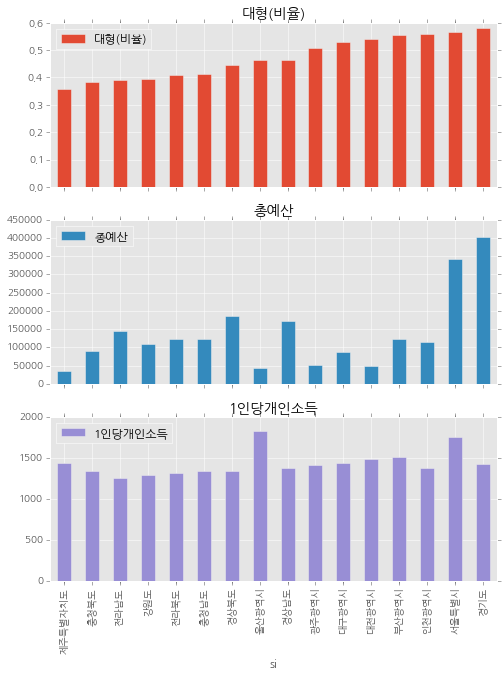

In [23]:
# Graph
merge.plot(kind='bar',subplots=True, figsize=(8,10))

In [24]:
# Correlation  
def plot_relation( ds, x, y, c, ylim=(0,500000) ):
    plt.xlim(.35,.65)
    plt.ylim(ylim[0],ylim[1])
    plt.scatter(ds[x], ds[y], alpha=0.6, s=50, c=c) 
    for idx, row in ds.iterrows():
        plt.text(row[x], row[y],idx )
    plt.xlabel(x)
    plt.ylabel(y)
    # 추세선 그린다.
    trendfun = np.poly1d(np.polyfit(ds[x], ds[y], 1))
    trendx = np.linspace(0.3, 0.62, 4)
    plt.plot(trendx, trendfun(trendx), color=c) 
    r = sp.stats.pearsonr(ds[x],ds[y])
    plt.text(trendx[3], trendfun(trendx[3]),'r={:.3f}'.format(r[0]), color = c )
    plt.tight_layout()


#### 상세히 관계를 비교해 보기 위해 먼저 대형(비율)과  지방(시도) 총예산 상관 관계를 보자 

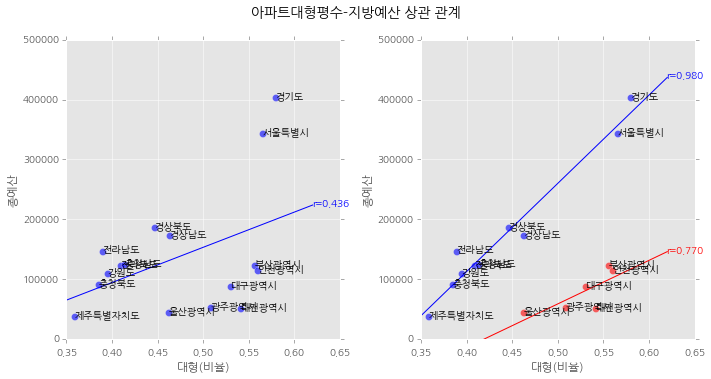

In [25]:
# 총예산 연관도 측정 
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plot_relation( merge, '대형(비율)', '총예산', 'b' )

# 광역시, 도를 구분하여 연관도 측정
plt.subplot(1, 2, 2)
plot_relation( merge[[not x.endswith('광역시') for x in merge.index]], '대형(비율)', '총예산', 'b' )
plt.subplot(1, 2, 2)
plot_relation( merge[[ x.endswith('광역시') for x in merge.index]], '대형(비율)', '총예산', 'r' )
plt.suptitle('아파트대형평수-지방예산 상관 관계', fontsize=14, y=1.05)


#### 상세히 관계를 비교해 보기 위해 먼저 대형(비율)과  1인당 개인소득과 상관 관계를 보자 

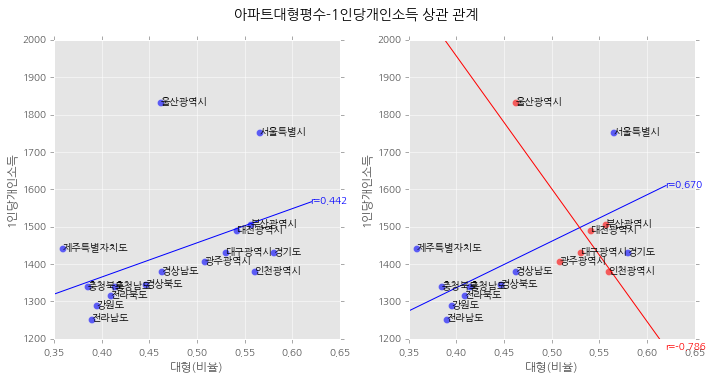

In [26]:
# Budget
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plot_relation( merge, '대형(비율)', '1인당개인소득', 'b' , ylim=(1200,2000))

# Province / city
plt.subplot(1, 2, 2)
plot_relation( merge[[not x.endswith('광역시') for x in merge.index]], '대형(비율)', '1인당개인소득', 'b', ylim=(1200,2000) )
plt.subplot(1, 2, 2)
plot_relation( merge[[ x.endswith('광역시') for x in merge.index]], '대형(비율)', '1인당개인소득', 'r', ylim=(1200,2000))
plt.suptitle('아파트대형평수-1인당개인소득 상관 관계', fontsize=14, y=1.05)
